Jupyter notebook for project

NLP applied to Kaggle dataset
Dataset here:
https://www.kaggle.com/datasets/stackoverflow/stacksample

Relevant NLP example:
https://github.com/Idilismiguzel/NLP-with-Python/blob/master/Text-Classification.ipynb

Possible BERT reference:
https://www.tensorflow.org/text/tutorials/classify_text_with_bert



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_style

set_style("whitegrid")

## Read in the data (part of it) and just look at it for a bit

In [116]:
questions = pd.read_csv("archive/Questions.csv", encoding = "ISO-8859-1", nrows=5000)
#answers = pd.read_csv("archive/Answers.csv", encoding = "ISO-8859-1", nrows=5000)
#tags = pd.read_csv("archive/Tags.csv", encoding = "ISO-8859-1", nrows=5000)

In [3]:
questions.sample(5, random_state=234)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
2439,194650,1384652.0,2008-10-11T21:08:57Z,NaN,7,2D Javascript array,"<p>Simply put, is there a way to create a 2D j..."
4573,326770,39975.0,2008-11-28T22:07:18Z,NaN,5,How can I dynamically get the set of classes f...,<p>I have a python module that defines a numbe...
2152,174380,25492.0,2008-10-06T13:55:30Z,NaN,3,Spring webflow : Move through view states,"<p>Within a spring webflow, i need to implemen..."
3689,274770,12252.0,2008-11-08T14:24:31Z,NaN,0,Session is lost with login control in Internet...,<p>After logging in using the Login control th...
3853,284090,6091.0,2008-11-12T14:26:00Z,NaN,5,How to get a ReadOnlyCollection<T> of the Keys...,"<p>My class contains a <code>Dictionary&lt;T, ..."


In [4]:
print(questions.iloc[2439].Body)

<p>Simply put, is there a way to create a 2D javascript array using similar syntax to this?</p>

<pre><code>var newArray = [
    [0, 1, 2],
    [3, 4, 5],
    [6, 7, 8]
]
</code></pre>



In [117]:
#answers.sample(5,random_state=505)

In [118]:
#print(answers.iloc[4162].Body)

In [119]:
#tags.sample(5, random_state=23)

## Confirm we actually read in as many rows as we thought, then count how many of those questions have been closed

In [8]:
np.shape(questions)[0]

5000

In [9]:
count = 0
for i in range(0,np.shape(questions)[0]):
    if pd.isna(questions.iloc[i].ClosedDate):
        count = count+1
        
print(count)

4618


In [10]:
np.shape(questions)[0] - count

382

## Start looking at the scores. How many of these first 5000 questions have what score?

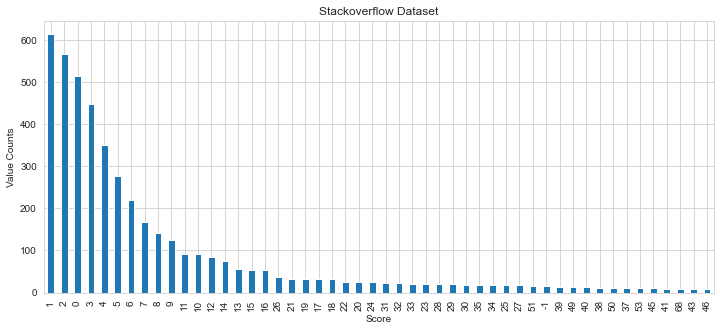

In [41]:
ax = questions['Score'].value_counts()[0:50].plot(kind='bar', figsize=(12,5))
fig = ax.get_figure()
ax.set_title("Stackoverflow Dataset")
ax.set_xlabel('Score')
ax.set_ylabel('Value Counts');

In [4]:
totals = questions['Score'].value_counts()

numbers = 0
for i in range(0,np.shape(totals)[0]):
    numbers = numbers + totals.iloc[i]

print(numbers)

5000


In [42]:
np.shape(totals)

(259,)

In [44]:
print(totals)

1       615
2       566
0       515
3       448
4       350
       ... 
114       1
192       1
446       1
367       1
5190      1
Name: Score, Length: 259, dtype: int64


## Find average score for this subset of data

In [47]:
print("Sum of scores for these questions is:", questions['Score'].sum())
print("Total number of questions is:", np.shape(questions)[0])
print("Number of unique score values is:", np.shape(totals)[0])

Sum of scores for these questions is:  120757
Total number of questions is:  5000
Number of unique score values is:  259


In [50]:
print("Mean of these scores is:", questions['Score'].mean())
print("Manual check of that mean:", questions['Score'].sum()/np.shape(questions)[0])
print("Median of these scores is:", questions['Score'].median())

Mean of these scores is: 24.1514
Manual check of that mean: 24.1514
Median of these scores is: 4.0


## Is there a connection between "closed" and "score"?

In [67]:
open_questions = questions[pd.isna(questions['ClosedDate'])].copy()
np.shape(open_questions)[0]

4618

In [68]:
closed_questions = questions[pd.notna(questions['ClosedDate'])].copy()
np.shape(closed_questions)[0]

382

In [59]:
print("Sum of scores for these open questions is:", open_questions['Score'].sum())
print("Total number of open questions is:", np.shape(open_questions)[0])
print("Number of unique score values is:", np.shape(open_questions['Score'].value_counts())[0])
print("Mean of these open question scores is:", open_questions['Score'].mean())
print("Median of these open question scores is:", open_questions['Score'].median())

Sum of scores for these open questions is: 107110
Total number of open questions is: 4618
Number of unique score values is: 246
Mean of these open question scores is: 23.19402338674751
Median of these open question scores is: 4.0


In [60]:
print("Sum of scores for these closed questions is:", closed_questions['Score'].sum())
print("Total number of closed questions is:", np.shape(closed_questions)[0])
print("Number of unique score values is:", np.shape(closed_questions['Score'].value_counts())[0])
print("Mean of these closed question scores is:", closed_questions['Score'].mean())
print("Median of these closed question scores is:", closed_questions['Score'].median())

Sum of scores for these closed questions is: 13647
Total number of closed questions is: 382
Number of unique score values is: 101
Mean of these closed question scores is: 35.725130890052355
Median of these closed question scores is: 9.5


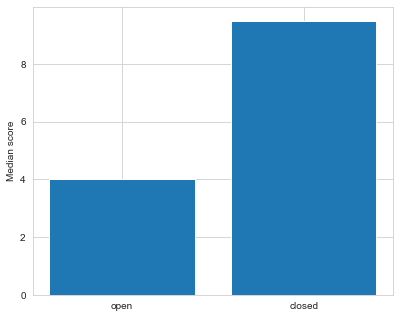

In [66]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_axes([0,0,1,1])
status = ['open', 'closed']
values = [open_questions['Score'].median(),closed_questions['Score'].median()]
ax.bar(status, values)
ax.set_ylabel("Median score")
plt.show()

So maybe there's a correlation between whether a question is closed/open and its score. That is, here at least, closed questions have a higher median score than open questions. Thus we should determine what properties of a question (the actual words) lead to a question becoming closed.

## Use Beautifulsoup to remove the html tags

In [26]:
from bs4 import BeautifulSoup

In [27]:
questions.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [28]:
print(questions.iloc[1].Body)

<p>Are there any really good tutorials explaining <a href="http://svnbook.red-bean.com/en/1.8/svn.branchmerge.html" rel="nofollow">branching and merging</a> with Apache Subversion? </p>

<p>All the better if it's specific to TortoiseSVN client.</p>



In [113]:
soup = BeautifulSoup(questions.iloc[1].Body)
text = soup.get_text()
print(text)

Are there any really good tutorials explaining branching and merging with Apache Subversion? 
All the better if it's specific to TortoiseSVN client.



## Use spaCy to break down important words

In [114]:
import spacy

nlp = spacy.load('en_core_web_sm')

For whatever reason, the BeautifulSoup output still contains newline characters. We can remove them. (For some reason spaCy doesn't care about newline characters when looking for words, but it does when you lemmatize.)

In [108]:
import re

In [115]:
print(repr(text))                # prints the raw string so we can see the newline characters
text = re.sub(r'\n','',text)
print(repr(text))

"Are there any really good tutorials explaining branching and merging with Apache Subversion? \nAll the better if it's specific to TortoiseSVN client.\n"
"Are there any really good tutorials explaining branching and merging with Apache Subversion? All the better if it's specific to TortoiseSVN client."


In [110]:
doc = nlp(text)
print(doc)

Are there any really good tutorials explaining branching and merging with Apache Subversion? All the better if it's specific to TortoiseSVN client.


In [111]:
# Return only the words in the sentence

doc_words_only = [token for token in doc if not token.is_punct | token.is_space]
print("Words only: \n", doc_words_only, "\n")

doc_punct_only = [token for token in doc if token.is_punct]
print("Punctuation is: \n", doc_punct_only)

Words only: 
 [Are, there, any, really, good, tutorials, explaining, branching, and, merging, with, Apache, Subversion, All, the, better, if, it, 's, specific, to, TortoiseSVN, client] 

Punctuation is: 
 [?, .]


For the above example, we're returning all words, without regard to if they're "stop words" or if they're the different versions of the same/similar words, e.g. good, better, best.

spaCy can both identify stop words and "lemmatize" for us to identify words with similar meanings. 

In [112]:
doc_nostop = [token.lemma_ for token in doc if not token.is_stop | token.is_punct]
doc_stops = [token.lemma_ for token in doc if token.is_stop]


print("Important, unique words are: \n", doc_nostop, "\n")
print("Stop words are: \n", doc_stops)


Important, unique words are: 
 ['good', 'tutorial', 'explain', 'branching', 'merge', 'Apache', 'Subversion', 'well', 'specific', 'TortoiseSVN', 'client'] 

Stop words are: 
 ['be', 'there', 'any', 'really', 'and', 'with', 'all', 'the', 'if', 'it', 'be', 'to']


Is might be possible to just identify words, then identify stop words, and subtract the two lists. But "words only" above isn't doing contractions correctly, so I didn't try that.

With cleaned and lemmatized text, I think we now need to actually make the bag-of-words? Though people (the github reference and the first link that comes up on google when I search for bag-of-word models) seem to like these n-grams, so let's make some of those first.

In [135]:
doc2stop = doc_nostop + doc_nostop
print(doc2stop)

['good', 'tutorial', 'explain', 'branching', 'merge', 'Apache', 'Subversion', 'well', 'specific', 'TortoiseSVN', 'client', 'good', 'tutorial', 'explain', 'branching', 'merge', 'Apache', 'Subversion', 'well', 'specific', 'TortoiseSVN', 'client']


In [120]:
from sklearn.feature_extraction.text import CountVectorizer

In [133]:
onegram_converter = CountVectorizer(lowercase=False)    # this is the name of the model, so we're just making the object
                                                        # lowercase=False preserves uppercase words; uncertain if this important
x = onegram_converter.fit_transform(doc_nostop)         # we fit the model to our words

words = onegram_converter.get_feature_names_out()       # "words" is now a list of all the words in our document

print(words)                                           # this would print all the unique words in our document
len(words)                                              # this is the number of unique words in our document

['Apache' 'Subversion' 'TortoiseSVN' 'branching' 'client' 'explain' 'good'
 'merge' 'specific' 'tutorial' 'well']


11

In [136]:
twogram_converter = CountVectorizer(ngram_range=[2,2], lowercase=False)                                                        
x2 = twogram_converter.fit_transform(doc2stop)         

bigrams = twogram_converter.get_feature_names_out()       # "bigrams" is now a list of all the 2-word combinations in our document

print(bigrams)                                           # this would print all the unique 2-words in our document
len(bigrams)    

ValueError: empty vocabulary; perhaps the documents only contain stop words